In [11]:
import numpy as np
import torch
import sys
from utils import *
from matplotlib import pyplot as plt
import torch.nn as nn
import time
from numba import cuda
from tqdm import tqdm, trange
import os
import pyroc
import pandas as pd
import gc
import scipy
from IPython.display import clear_output
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="6"  
device = torch.device("cuda:0")
dtype = torch.float32
torch.manual_seed(42)
np.random.seed(42)

dataset = np.load('HIGGS.npy')
dataset_P = dataset[dataset[:,0]==0][:, 1:] # background (5829122, 28)
dataset_Q = dataset[dataset[:,0]==1][:, 1:] # signal     (5170877, 28)

In [12]:

H = 500
out= 100
L = 1
class DN(torch.nn.Module):
    def __init__(self, H=300, out=100, x_in=28):
        super(DN, self).__init__()
        self.restored = False
        self.model = torch.nn.Sequential(
            torch.nn.Linear(x_in, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, out, bias=True),
        )
    def forward(self, input):
        output = self.model(input)
        return output

class another_DN(torch.nn.Module):
    def __init__(self, H=300, x_in=28):
        super(another_DN, self).__init__()
        self.restored = False
        self.model = torch.nn.Sequential(
            torch.nn.Linear(x_in, H, bias=True),
            torch.nn.Tanh(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.Tanh(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.Tanh(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.Tanh(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.Tanh(),
            torch.nn.Linear(H, x_in, bias=True),
        )
    def forward(self, input):
        output = self.model(input) + input
        return output

class Classifier(torch.nn.Module):
    def __init__(self, H=300, layers = 5, x_in=28):
        super(Classifier, self).__init__()
        self.restored = False
        self.model = torch.nn.Sequential(
            torch.nn.Linear(x_in, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, 1, bias=True),
            torch.nn.Sigmoid(),
        )
        if layers == 6:
            self.model = torch.nn.Sequential(
                torch.nn.Linear(x_in, H, bias=True),
                torch.nn.ReLU(),
                torch.nn.Linear(H, H, bias=True),
                torch.nn.ReLU(),
                torch.nn.Linear(H, H, bias=True),
                torch.nn.ReLU(),
                torch.nn.Linear(H, H, bias=True),
                torch.nn.ReLU(),
                torch.nn.Linear(H, H, bias=True),
                torch.nn.ReLU(),
                torch.nn.Linear(H, 1, bias=True),
                torch.nn.Sigmoid(),
            )
    def forward(self, input):
        output = self.model(input)
        return output

In [13]:
n = 1300101
epoch = 35
path = './checkpoint%d/'%n+str(epoch)+'/'
path = './Scheffe/checkpoint1299999/50/'
#path = './Gaussian/checkpoint%d/'%n+str(epoch)+'/'
#path = './Fea_Gau/checkpoint%d/'%n+str(epoch)+'/'



In [14]:
model = DN(300, 100, x_in=28).cuda()
another_model = another_DN(300, x_in=28).cuda()
model = Classifier(300, 6).cuda()
model,another_model,epsilonOPT,sigmaOPT,sigma0OPT,cst = load_model(model, another_model, path)
epsilonOPT


Scheffe


'Scheffe'

auc =  [[0.84671262]]
saved roc.png
saved hist.png...


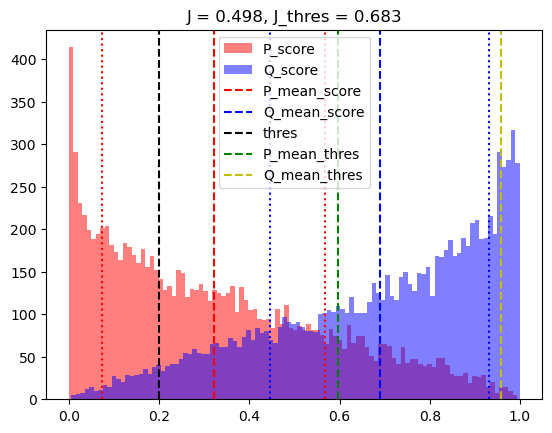

In [15]:
gc.collect()
torch.cuda.empty_cache()
M = 10000
# dataset_P = dataset_P[:,21:28]
# dataset_Q = dataset_Q[:,21:28]
Z = np.concatenate((dataset_P[np.random.choice(dataset_P.shape[0], M, replace=False)],
            dataset_Q[np.random.choice(dataset_Q.shape[0], M, replace=False)]), axis=0)
Z = MatConvert(Z, device, dtype)
PQhat = compute_score_func(Z, dataset_P, dataset_Q, 
            model, another_model, epsilonOPT, sigmaOPT, sigma0OPT, cst,M=10000)
PQhat = PQhat.cpu().detach().numpy()
auc, x, y = get_auc_and_x_and_y(PQhat)
print('auc = ', auc)
# plt.plot(x, y, label='AUC = %.2f'%auc)
# plt.legend()
# plt.xlabel('Signal Efficiency')
# plt.ylabel('Background Rejection')
# plt.title('ROC Curve')
# plt.savefig('roc.png')
print('saved roc.png')

fig = plot_hist(PQhat[:M], PQhat[M:])

P_scores = PQhat[:M]
Q_scores = PQhat[M:]
P_mean_score = np.mean(P_scores)
Q_mean_score = np.mean(Q_scores)
P_std_score = np.std(P_scores)
Q_std_score = np.std(Q_scores)
J = (Q_mean_score - P_mean_score) / (np.sqrt(P_std_score**2 + Q_std_score*2))
thres = 0.2
delta = np.max(PQhat) - np.min(PQhat)
P_mean_thres = np.mean([PQhat[:M]>thres])*delta + np.min(PQhat)
Q_mean_thres = np.mean([PQhat[M:]>thres])*delta + np.min(PQhat)
J_thres = (Q_mean_thres - P_mean_thres) / (np.sqrt(P_mean_thres*(1-P_mean_thres) + Q_mean_thres*(1-Q_mean_thres)))
# 竖线
plt.axvline(x=thres, color='k', linestyle='--', label = 'thres')
plt.axvline(x=P_mean_thres, color='g', linestyle='--', label = 'P_mean_thres')
# plt.axvline(x=P_mean_thres - np.sqrt(np.mean([PQhat[:M]>thres])* np.mean([PQhat[:M]<thres]))*delta, color='g', linestyle='--')
# plt.axvline(x=P_mean_thres + np.sqrt(np.mean([PQhat[:M]>thres])* np.mean([PQhat[:M]<thres]))*delta, color='g', linestyle='--')
plt.axvline(x=Q_mean_thres, color='y', linestyle='--', label = 'Q_mean_thres')
# plt.axvline(x=Q_mean_thres - np.sqrt(np.mean([PQhat[M:]>thres])* np.mean([PQhat[M:]<thres]))*delta, color='y', linestyle='--')
# plt.axvline(x=Q_mean_thres + np.sqrt(np.mean([PQhat[M:]>thres])* np.mean([PQhat[M:]<thres]))*delta, color='y', linestyle='--')
plt.title('J = {:.3f}, J_thres = {:.3f}'.format(J, J_thres))
plt.legend()
# P是background, Q是signal

In [16]:
p_no_thres = get_pval(PQhat[:M], PQhat[M:], thres=None)*np.sqrt(1100)
print('no thres p-value = %.3f'%p_no_thres)

no thres p-value = 4.487


In [17]:
thres = 0.2
p_thres = get_pval(PQhat[:M], PQhat[M:], thres=thres)*np.sqrt(1100)
print('thres-ed at %.2f, p-value = %.3f'%(thres,p_thres))

thres-ed at 0.20, p-value = 2.223


In [18]:
scipy.stats.binom.cdf(1000, 1100, 1-0.01)

6.824866922823888e-61

In [19]:
def plot_pval_thres(PQhat, color=None, label=None):
    auc, x, y = get_auc_and_x_and_y(PQhat)
    # Find the true p of threshold
    p_list = np.zeros(len(x))
    for i in trange(len(x)):
        a = x[i] # sig->sig
        b = y[i] # bkg->bkg 
        if a==0 or b==0 or a==1 or b==1:
            continue
        E = 100*a+1000*(1-b)
        p_val = scipy.stats.binom.cdf(E, 1100, 1-b)
        p_list[i] = scipy.stats.norm.ppf(p_val)
    print(np.max(p_list))
    i = np.argmax(p_list)
    print('(',x[i], y[i],')')
    # sort
    sorted = np.sort(PQhat, axis=None)
    print('best thres at ',sorted[i])
    plt.plot(sorted[0:len(x)], p_list, color=color)
    plt.xlabel('Threshold on phi(z)')
    plt.ylabel('p-value')
    # 横线
    p_no_thres = get_pval(PQhat[:M], PQhat[M:], thres=None)*np.sqrt(1100)
    plt.axhline(y=p_no_thres, linestyle='-', color=color, label=label)
    # plt.axhline(y=np.max(p_list), color='g', linestyle='-')
    plt.legend()
    return sorted[i]
plot_pval_thres(PQhat)

 26%|██▌       | 5136/19982 [00:01<00:03, 4082.64it/s]


KeyboardInterrupt: 

100%|██████████| 19991/19991 [00:05<00:00, 3988.44it/s]


5.797169566201129
( 0.2152 0.9925 )
best thres at  0.9263887


IndexError: list index out of range

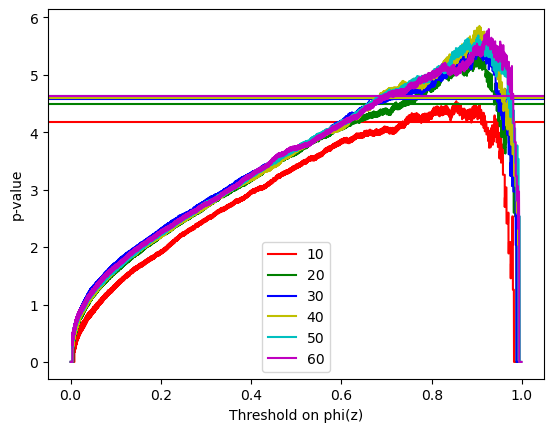

In [ ]:
gc.collect()
torch.cuda.empty_cache()
Z = np.concatenate((dataset_P[np.random.choice(dataset_P.shape[0], 10000, replace=False)],
            dataset_Q[np.random.choice(dataset_Q.shape[0], 10000, replace=False)]), axis=0)
Z = MatConvert(Z, device, dtype)
color_list = ['r','g','b','y','c','m']
model = DN(300, 100, x_in=28).cuda()
model = Classifier(300, 6).cuda()
another_model = another_DN(300, x_in=28).cuda()
for i, epoch in enumerate([10,20,30,40,50,60,70,80,90,100]):
    color = color_list[i]
    path = './Scheffe/checkpoint1299999/%d/'%epoch
    model,another_model,epsilonOPT,sigmaOPT,sigma0OPT,cst = load_model(model, another_model, path)
    # assign value to tensor epsilonOPT
    PQhat = compute_score_func(Z, dataset_P, dataset_Q, 
                model, another_model, epsilonOPT, sigmaOPT, sigma0OPT, cst,
                M = 1000)
    PQhat = PQhat.cpu().detach().numpy()
    clear_output()
    plot_pval_thres(PQhat, color=color, label = str(epoch))
plt.axhline(y=5, linestyle='--', color='k')

In [ ]:
np.random.shuffle(dataset_P)


In [ ]:
dataset_P[np.random.permutation(dataset_P.shape[0])]

array([[ 1.06090379,  0.04864428,  1.57400322, ...,  0.55522215,
         0.76240456,  0.75164694],
       [ 1.83814335, -0.55716431, -0.9002288 , ...,  0.27510253,
         0.60097969,  0.61276448],
       [ 1.07170129, -0.76169777, -0.68660718, ...,  0.60223007,
         0.99775726,  0.97290868],
       ...,
       [ 0.5385958 ,  2.07449961,  0.36662507, ...,  0.88684291,
         1.09597981,  1.12875116],
       [ 2.56139541, -0.08868531, -0.06848887, ...,  1.61864674,
         1.20942509,  1.02677035],
       [ 0.67329049, -0.49677822,  0.16021663, ...,  1.06153154,
         1.13860846,  1.06118107]])

In [ ]:
for i in range(2**28):
    print(np.log2(i))
    clear_output()

NameError: name 'np' is not defined